In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("..")
from src.dataset import SIModel
from src.approx_bc import abc_rejection_sampler, abc_rejection_sampler2
import seaborn as sns
from scipy.stats import norm, lognorm
import matplotlib

In [2]:
run_abc = False

In [3]:
sns.set_theme()
sns.set_style("white")

matplotlib.rcParams['figure.figsize'] = (6.4, 4.8)

beta_true = 0.15 # 0.15
alpha = 0.1
gamma = 0.05 # 0.05
prior_mu = -3
prior_sigma = 1
N = 100
T = 52
K = 30
heterogeneous = False
log_scale = False

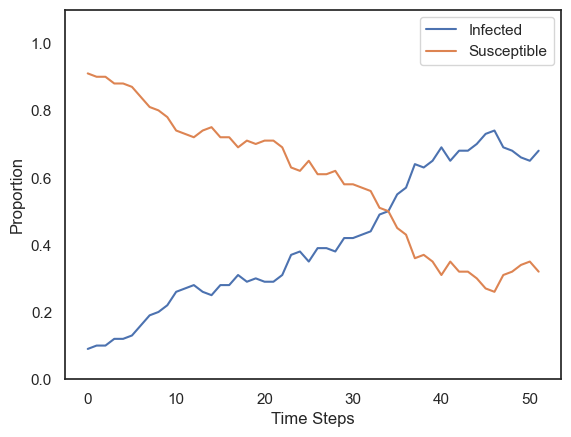

In [4]:
si_model = SIModel(alpha, gamma, beta_true, 
                    heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False, log_scale = False)

x_o_raw = si_model.get_observed_data(29)
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Infected")
plt.plot(S_o, label="Susceptible")
plt.legend(loc="upper right")
plt.xlabel("Time Steps")
plt.ylabel("Proportion")
plt.ylim(0, 1.1)
# plt.savefig("images/si-sim.png")
plt.show()

## Likelihood-based

In [27]:
true_post_mean = -1.99
true_post_sd = 0.0949
true_post_exp = 0.137

## NPE

In [28]:
npe_results = {
    "Method": ["NPE"] * 6,
    "Simulations": [125, 250, 500, 1000, 2000, 4000],
    "mean": [-1.914, -1.972, -1.95, -2.013, -1.971, -1.985],
    "sd": [.162, .156, 0.139, .151, .125, .145]
}
df_npe = pd.DataFrame(npe_results)
df_npe["Posterior Mean"] = np.exp(df_npe["mean"] + df_npe["sd"]**2/2)
# df_npe[".05"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.05))
# df_npe[".95"] = np.exp(norm(df_npe["mean"], df_npe["sd"]).ppf(0.95))

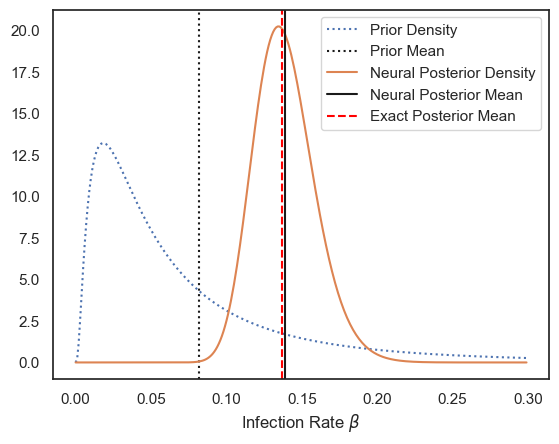

In [29]:
mu = df_npe["mean"].iloc[-1]
sigma = df_npe["sd"].iloc[-1]

prior_mean = np.exp(prior_mu + prior_sigma**2/2)

prior = norm(prior_mu, prior_sigma)

np.random.seed(10)
x = np.arange(0., 0.3, 0.001)
ax1 = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(prior_mu), s=prior_sigma), 
                   label="Prior Density", linestyle=":")
posterior_mean = np.exp(mu + sigma**2/2)
plt.axvline(prior_mean, color="k", linestyle=":", label="Prior Mean")
ax = sns.lineplot(x=x, y=lognorm.pdf(x, scale=np.exp(mu), s=sigma), label="Neural Posterior Density")
plt.axvline(posterior_mean, color="k", label="Neural Posterior Mean")
plt.axvline(true_post_exp, color="red", linestyle="--", label=r"Exact Posterior Mean")
ax.set_xlabel(r"Infection Rate $\beta$")
# ax.set_title(f"Neural Posterior Inference of Infection Rate")
plt.legend()
plt.savefig("images/npe_homog.png")
plt.show()

## Posterior Predictive Checks

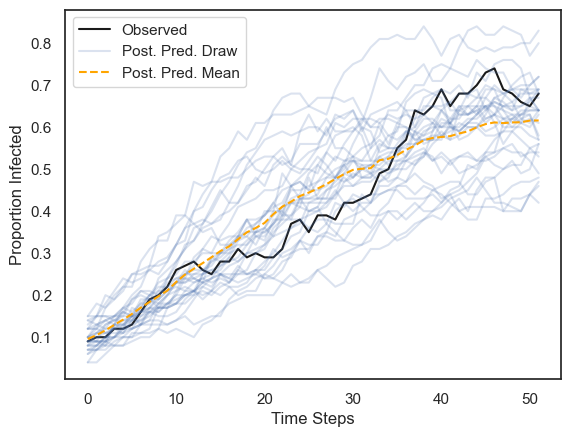

In [31]:
neural_posterior = norm(mu, sigma)
K = 30
npe_sample = np.exp(neural_posterior.rvs(size=K, random_state=2))
posterior_predictive = np.empty((K, T))


for i in range(K):
    si_model = SIModel(alpha, gamma, npe_sample[i], 
                   heterogeneous, prior_mu, prior_sigma,
                   N, T, summarize=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.savefig("images/ppc.png")
plt.show()

## ABC

In [92]:
if run_abc: 
    abc_data = {"summarize":[], "epsilon":[], "simulations":[]}
    abc_samples = []
    
    args = [(False, [2, 1, 0.8, 0.65, 0.5]),
            (True, [0.4, 0.25, 0.1, 0.05, 0.01])]
    for summarize, es in args:
        for epsilon in es:
            si_model = SIModel(alpha, gamma, beta_true, 
                            heterogeneous, prior_mu, prior_sigma, 
                           N, T, summarize=summarize)
            prior_sampler = lambda: si_model.sample_logbeta(1)
            simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
            x_o = si_model.get_observed_data(29)
            if summarize:
                x_o = x_o.transpose(0, 1)
            S = 100
            print(f"epsilon: {epsilon}")
            posterior_sample, errors = abc_rejection_sampler(
                S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
                summarize=summarize
                )
            print("***")
            abc_data["summarize"].append(summarize)
            abc_data["epsilon"].append(epsilon)
            abc_data["simulations"].append((errors > 0).sum())
            abc_samples.append(posterior_sample[:,0])

epsilon: 2
Time lapsed: 0.26 seconds
With tolerance 2, acceptance rate: 0.487805
Total number of attempts: 205
***
epsilon: 1
Time lapsed: 0.81 seconds
With tolerance 1, acceptance rate: 0.140056
Total number of attempts: 714
***
epsilon: 0.8
Time lapsed: 1.19 seconds
With tolerance 0.8, acceptance rate: 0.090171
Total number of attempts: 1,109
***
epsilon: 0.65
Time lapsed: 2.50 seconds
With tolerance 0.65, acceptance rate: 0.042644
Total number of attempts: 2,345
***
epsilon: 0.5
Attempts: 5,000
Time lapsed: 7.00 seconds
With tolerance 0.5, acceptance rate: 0.015485
Total number of attempts: 6,458
***
epsilon: 0.4
Time lapsed: 0.11 seconds
With tolerance 0.4, acceptance rate: 1.000000
Total number of attempts: 100
***
epsilon: 0.25
Time lapsed: 0.20 seconds
With tolerance 0.25, acceptance rate: 0.546448
Total number of attempts: 183
***
epsilon: 0.1
Time lapsed: 0.78 seconds
With tolerance 0.1, acceptance rate: 0.137552
Total number of attempts: 727
***
epsilon: 0.05
Time lapsed: 1.2

In [ ]:
if run_abc:
    df_abc = pd.DataFrame(abc_data)

    abc_posterior = np.array(abc_samples)
    df_abc["Posterior Mean"] = np.exp(abc_posterior).mean(1)
    
    # df_abc[".05"] = np.quantile(np.exp(abc_posterior), 0.05, 1)
    # df_abc[".95"] = np.quantile(np.exp(abc_posterior), 0.95, 1)
    df_abc["sd"] = abc_posterior.std(1)
    df_abc["mean"] = abc_posterior.mean(1)
    df_abc["Method"] = df_abc["summarize"].apply(lambda x: "ABC-S" if x else "ABC")
    df_abc = df_abc.rename(columns={"simulations":"Simulations"})

    df_results = pd.concat([df_npe, 
           df_abc[["Method", "Simulations", "Posterior Mean", "mean", "sd"]]])
    df_results.to_csv("homogeneous_accuracy.csv", index=False)

In [33]:
if not run_abc:
    df_results = pd.read_csv("homogeneous_accuracy.csv")

In [35]:
npe = df_results[df_results["Method"] == "NPE"]
abc = df_results[df_results["Method"] == "ABC"]
abcs = df_results[df_results["Method"] == "ABC-S"]

In [36]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

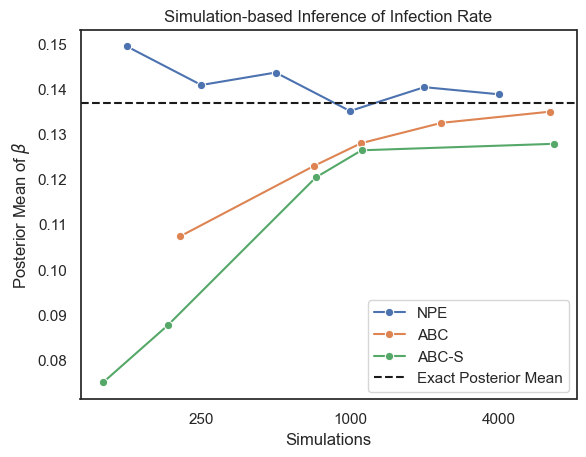

In [37]:
ax = sns.lineplot(df_results, x="Simulations", y="Posterior Mean", marker="o", hue="Method")
ax.axhline(y = true_post_exp, color="k", label=r"Exact Posterior Mean", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean of $\beta$")
plt.title("Simulation-based Inference of Infection Rate")

ax.set_xticks([250, 1000, 4000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

plt.show()

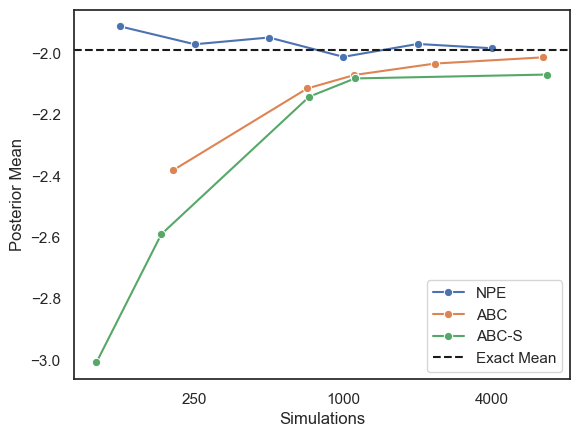

In [74]:
ax = sns.lineplot(df_results, x="Simulations", y="mean", marker="o", hue="Method")
ax.axhline(y = true_post_mean, color="k", label=r"Exact Mean", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Mean")
ax.set_xticks([250, 1000, 4000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.savefig("images/homog_bias.png")
plt.show()

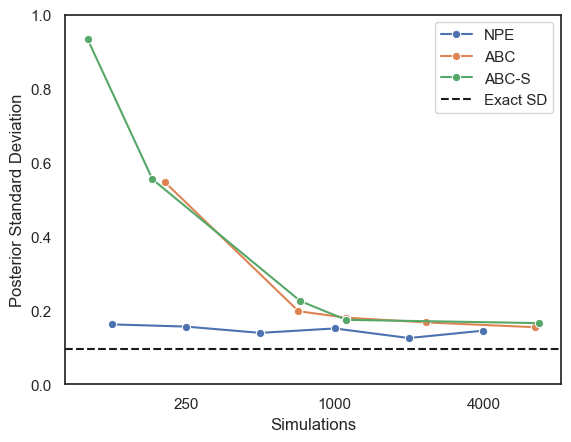

In [75]:
ax = sns.lineplot(df_results, x="Simulations", y="sd", marker="o", hue="Method")
plt.legend()
ax.axhline(y = true_post_sd, color="k", label=r"Exact SD", linestyle="--")
plt.legend()
plt.xscale("log")
plt.xlabel("Simulations")
plt.ylabel(r"Posterior Standard Deviation")
# plt.title("Simulation-based Inference of Infection Rate")
ax.set_xticks([250, 1000, 4000])
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.ylim(0,1)
plt.savefig("images/homog_variance.png")
plt.show()

# Prior Strength 

## Prior Precision

In [63]:
prior_precision = pd.read_csv("prior_precision.csv")
prior_precision = prior_precision[["prior_sigma", "mu", "sigma", "n_sample"]]
prior_precision["method"] = "NPE"

In [64]:
# testing

if run_abc:
    prior_strength_abc = {"prior_sigma": [], "mu": [],
                          "sigma": [],
                          "n_sample": []}
    n_accepts = 50
    for prior_sigma in 4,2,1,0.5,0.25:
        for S in [500]:# , 2000:
            prior_mu = -1.9
            summarize = False
            si_model = SIModel(alpha, gamma, beta_true, 
                            heterogeneous, prior_mu, prior_sigma, 
                        N, T, summarize=summarize)
            prior_sampler = lambda: si_model.sample_logbeta(1)
            simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
            x_o = si_model.get_observed_data(29)
            posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
            accepted = posterior_sample[errors.argsort()[:n_accepts]]
            prior_strength_abc["prior_sigma"].append(prior_sigma)
            prior_strength_abc["mu"].append(accepted.mean())
            prior_strength_abc["sigma"].append(accepted.std())
            # prior_strength_abc["posterior_mean"].append(np.exp(accepted).mean())
            prior_strength_abc["n_sample"].append(S)

    df_prior_strength = pd.DataFrame(prior_strength_abc)
    df_prior_strength.to_csv("abc_prior_precision.csv", index=False)

In [65]:
if not run_abc:
    df_prior_strength = pd.read_csv("abc_prior_precision.csv")
df_prior_strength["method"] = "ABC"

df_prior_strength = pd.concat([df_prior_strength, prior_precision])
df_prior_strength["log_precision"] = np.log2(df_prior_strength["prior_sigma"] ** -2)

df_prior_strength = df_prior_strength.sort_values(["method", "log_precision"])

df_ps_npe = df_prior_strength[df_prior_strength["method"] == "NPE"]
df_ps_abc = df_prior_strength[(df_prior_strength["method"] == "ABC")]

npe_error = df_ps_npe["sigma"]
abc_error = df_ps_abc["sigma"]
npe_lower, npe_upper = df_ps_npe["mu"] - npe_error, df_ps_npe["mu"] + npe_error

abc_lower, abc_upper = df_ps_abc["mu"] - abc_error, df_ps_abc["mu"] + abc_error

In [66]:
mle_est = -1.976

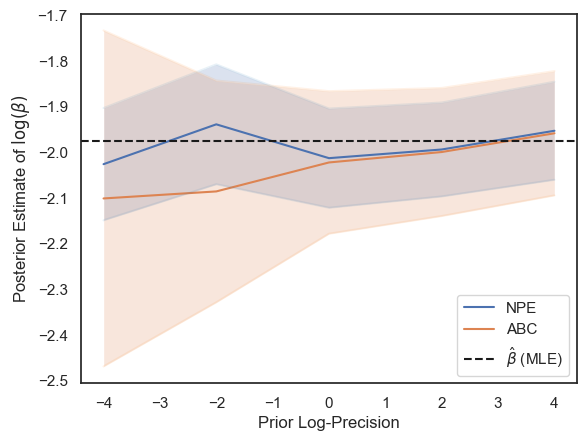

In [67]:
plt.plot(df_ps_npe["log_precision"], df_ps_npe["mu"], label="NPE")
plt.plot(df_ps_abc["log_precision"], df_ps_abc["mu"], label="ABC")
# plt.plot(df_ps_abc2["log_precision"], df_ps_abc2["mu"], label="ABC (2k)")
plt.axhline(mle_est, linestyle="--", color="k", label=r"$\hat \beta$ (MLE)")

plt.plot(df_ps_npe["log_precision"],
         npe_lower, color='tab:blue', alpha=0.1)
plt.plot(df_ps_npe["log_precision"],
         npe_upper, color='tab:blue', alpha=0.1)
plt.fill_between(df_ps_npe["log_precision"], npe_lower, npe_upper, alpha=0.2)

plt.plot(df_ps_npe["log_precision"],
         abc_lower, color='tab:orange', alpha=0.1)
plt.plot(df_ps_npe["log_precision"],
         abc_upper, color='tab:orange', alpha=0.1)
plt.fill_between(df_ps_npe["log_precision"], abc_lower, abc_upper, alpha=0.2)

plt.xlabel("Prior Log-Precision")
plt.ylabel(r"Posterior Estimate of $\log(\beta)$")
plt.legend()
plt.savefig("images/prior_precision.png")
plt.show()

In [68]:
df_prior_bias = pd.read_csv("prior_bias.csv")[["mu", "sigma", "prior_mu", "n_sample"]]
df_prior_bias["method"] = "NPE"

In [69]:
if run_abc:
    df_temp = []
    n_accepts=50
    for prior_mu in [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5]:
        S = 500
        prior_sigma = 1
        summarize = False
        si_model = SIModel(alpha, gamma, beta_true, 
                        heterogeneous, prior_mu, prior_sigma, 
                    N, T, summarize=summarize)
        prior_sampler = lambda: si_model.sample_logbeta(1)
        simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
        x_o = si_model.get_observed_data(29)
        posterior_sample, errors = abc_rejection_sampler2(S, prior_sampler, simulator, x_o, summarize)
        accepted = posterior_sample[errors.argsort()[:n_accepts]]
        df_temp.append([accepted.mean(), accepted.std(), prior_mu, S, "ABC"])
    
    df_temp = pd.DataFrame(df_temp, columns=["mu", "sigma", "prior_mu", "n_sample", "method"])
    
    df_temp.to_csv("abc_prior_bias.csv", index=False)
else:
    df_temp = pd.read_csv("abc_prior_bias.csv")

In [70]:
df_prior_mu = pd.concat([df_prior_bias, df_temp])

df_prior_mu = df_prior_mu.sort_values(["method", "prior_mu"])

df_pm_npe = df_prior_mu[df_prior_mu["method"] == "NPE"]
df_pm_abc = df_prior_mu[(df_prior_mu["method"] == "ABC")]


npe_error = df_pm_npe["sigma"]
abc_error = df_pm_abc["sigma"]

npe_lower, npe_upper = df_pm_npe["mu"] - npe_error, df_pm_npe["mu"] + npe_error

abc_lower, abc_upper = df_pm_abc["mu"] - abc_error, df_pm_abc["mu"] + abc_error

x = df_pm_npe["prior_mu"] - mle_est

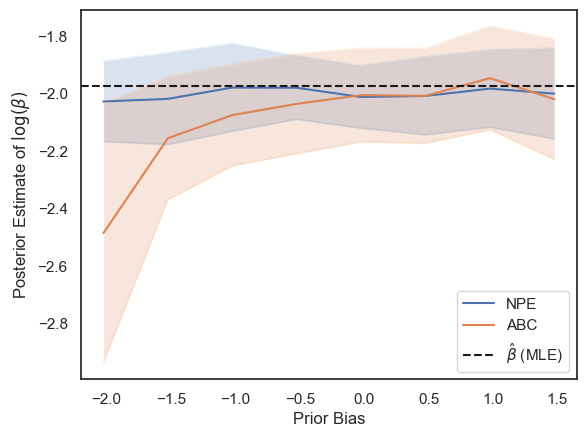

In [71]:
plt.plot(x, df_pm_npe["mu"], label="NPE")
plt.plot(x, df_pm_abc["mu"], label="ABC")

plt.axhline(mle_est, linestyle="--", color="k", label=r"$\hat \beta$ (MLE)")

plt.plot(x,
         npe_lower, color='tab:blue', alpha=0.1)
plt.plot(x,
         npe_upper, color='tab:blue', alpha=0.1)
plt.fill_between(x, npe_lower, npe_upper, alpha=0.2)

plt.plot(x,
         abc_lower, color='tab:orange', alpha=0.1)
plt.plot(x,
         abc_upper, color='tab:orange', alpha=0.1)
plt.fill_between(x, abc_lower, abc_upper, alpha=0.2)

plt.xlabel("Prior Bias")
plt.ylabel(r"Posterior Estimate of $\log(\beta)$")
plt.legend()
plt.savefig("images/prior_bias.png")
plt.show()

### Model Identifiability

In [62]:
prior_mu = np.zeros(7) - 4

In [64]:
si_model = SIModel(alpha, gamma, beta_true = [0.15, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8, 1e-8], heterogeneous = True,
                  prior_mu = prior_mu, prior_sigma = [1, 1, 1, 1, 1, 1, 1],
                  N=N, T=T, summarize=False)
prior_sampler = lambda: si_model.sample_logbeta(1)
simulator = lambda theta, seed: si_model.SI_simulator(theta, seed)
x_o = si_model.get_observed_data(29)

epsilon = 2.8


S = 100
print(f"epsilon: {epsilon}")
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=30000,
    summarize=False
    )

epsilon: 2.8
Attempts: 5,000
Time lapsed: 20.78 seconds
With tolerance 2.8, acceptance rate: 0.019720
Total number of attempts: 5,071


In [65]:
np.exp(posterior_sample).mean(0)

array([0.10135147, 0.02511423, 0.03496984, 0.02792519, 0.02804516,
       0.03027372, 0.02678665], dtype=float32)

In [70]:
np.exp(norm(-3, 1).ppf(0.05))

0.009610936338768283

In [67]:
a = np.quantile(np.exp(posterior_sample), 0.05, 0)
b = np.quantile(np.exp(posterior_sample), 0.95, 0)
list(zip(a, b))

[(0.06175974663347006, 0.15180288478732107),
 (0.0036120604723691944, 0.08067738488316531),
 (0.00410814315546304, 0.10402307882905006),
 (0.00341009059920907, 0.06994993947446344),
 (0.0037057666340842843, 0.07872619591653345),
 (0.0038843477377668023, 0.10898226387798784),
 (0.0037319508846849203, 0.09551773183047771)]

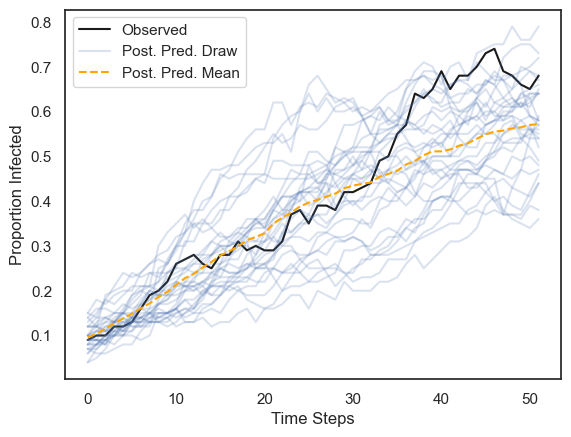

In [71]:
posterior_predictive = np.empty((K, T))
for i in range(K):
    si_model = SIModel(alpha, gamma, np.exp(posterior_sample)[i], 
                   True, prior_mu, [1, 1, 1, 1, 1, 1, 1],
                   N, T, summarize=False, flatten=False)
    x_rep = si_model.get_observed_data(i)
    posterior_predictive[i] =  np.array(x_rep)[0]
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = np.array(x_o_raw)[0]
S_o  = 1 - I_o
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.2)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
# plt.savefig("images/ppc.png")
plt.show()

In [ ]:
# posterior predictive check

In [ ]:
# (posterior_sample).mean(0)

In [14]:
posterior_sample.std(0)

array([0.22441374, 0.9633007 , 0.94178075, 0.93232065, 1.0651814 ,
       1.0455961 , 0.93671685], dtype=float32)

In [18]:
np.exp(-2.17 + 0.22)

0.1422740715865136

In [16]:
np.log(0.15)

-1.8971199848858813